This code generates lightcurves from a range of inclinations, field obliquities, and spatial offsets. It saves these light curves to CSV files to be read later and compared to real light curves from the TESS data. 

In [1]:
#Import the required libraries for this code
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy.linalg import norm
from scipy.spatial.transform import Rotation as R
from IPython.display import clear_output
import pandas as pd
pi = np.pi #Literally this is to avoid having to type np every time I want pi

In [2]:
#Input parameters
axSize= 5 #This is the axis size. Ex: if axSize = 10, the x,y, and z axes extend from -10 to 10, creating a 20x20x20 grid
gTicks = 32 #This is how many ticks are on the axis. Ex: if gTicks = 21, and axSize = 10, then there are 21 ticks ranging from -10 to 10 (zero included), and each tick is an interval of 1. 
starRadius = 1 #This is the radius of the star. Keep in mind the size of the axis and grid ticks when choosing a radius. 
#note to self, axSize/gTicks must be > starRadius. Star can't have radius <1 tick. 
rAxis = np.array([0,0,1]) #In this iteration of the code, I define the rotation axis to be straight up the Z axis
#Calculation Parameters
rTicks = 32 #Rotational ticks. In one stellar rotation, how many times should the optical depth be evaluated? Ex: if rTicks = 4, four calculations are made; 0, pi/2, pi, 3pi/2. 
#Generate grid
xAxis = np.linspace(-axSize, axSize, gTicks)
yAxis = np.linspace(-axSize, axSize, gTicks)
zAxis = np.linspace(-axSize, axSize, gTicks)

In [3]:
#Functions

def getB(r,m): #Equation for B field strength as a function of a vector r from the origin
    B = (3*r*(np.dot(m,r))/((magV(r))**5))-(m/((magV(r))**3))
    return magV(B) #return the magnitude of this field

def rotTrans(xi,yi,zi,rAngle): #Rotates a vector about a specified axis. 
    v = [xi,yi,zi]
    rVec = rAxis*rAngle
    rot = R.from_rotvec(rVec)
    vr = rot.apply(v)
    return(vr[0], vr[1], vr[2])
def getCylinderPoints():
    pEarth = np.array([axSize*np.sin(i), 0, axSize*np.cos(i)]) #Start with Earth in the X/Z plane relative to the star, Earth is on the edge of the grid
    cylinderPoints = np.array([[0,0,0]]) #The following nested loops save every point inside a cylinder (with the stars radius) from the origin to Earth to this array
    for x in xAxis:
            #clear_output(wait=True)
            #print("Intializing... ", ((x+axSize)/(2*axSize))*100, "%")
            for y in yAxis:
                for z in zAxis:
                    r = np.array([[x,y,z]]) #Vector from origin to point of interest
                    if magV(r[0]) >= starRadius:
                        if normDist(np.array([0,0,0]), pEarth, r[0]) <= starRadius: #If this vector is outside of the star and inside a cylinder with the radius of the star that extends to Earth, we want to calcualte B there
                            if magV(r[0] - np.array([starRadius*np.sin(i),0,starRadius*np.cos(i)])) <= magV(r[0] - np.array([-starRadius*np.sin(i),0,-starRadius*np.cos(i)])):
                                cylinderPoints = np.append(cylinderPoints,r, axis = 0)
    cylinderPoints = np.delete(cylinderPoints,0,0)
    return cylinderPoints
def getTau(angles):
    Taus = np.array([])
    cylinderPoints = getCylinderPoints()
    for angle in angles:  #Calculate for each rotation angle
        #clear_output(wait=True)
        #print("Calculating... ", ((angle-angles[0])/(max(angles)-angles[0])*100), "%")
        tauTotal = 0
        count = 0.0000000000000001 #Avoid a rare div/0 error when trying to calculate average but no points were valid (0 is in the numerator anyway)
        for point in cylinderPoints:
            r = np.array(rotTrans(point[0],point[1],point[2],angle))
            rB = r - O #Distance from point of interest to B field origin, (subtract the offset from r)
            tauTotal += getB(rB,m)
            count+=1
        avgTau = tauTotal/count
        Taus = np.append(Taus, avgTau)
    return(Taus)                    
                    
        
def magV(r): #Gets the magnitude of a 3D input vector
    return(np.sqrt((r[0]**2)+(r[1]**2)+(r[2]**2)))        
        
def normDist(p1,p2,p3): #Calculates the shortest distance between a line formed by p1 and p2, and a point p3. 
    return(magV(np.abs(np.cross(p2-p1, p1-p3)) / norm(p2-p1)))

In [56]:
#Curve generation parameters 
#Offset Parameters
offsetStart = 0
offsetStop = .4
offsetSteps =5
offsetRange = np.linspace(offsetStart, offsetStop, offsetSteps)
#Tilt Parameters 
tiltStart = 0
tiltStop = 4*pi/5
tiltSteps = 5
tiltRange = np.linspace(tiltStart, tiltStop, tiltSteps)

angles = np.linspace(0,2*pi,rTicks)
phase = angles/(2*pi)




In [57]:
stepTotal = (offsetSteps**3)*(tiltSteps**2)
stepCounter = 1
t0 = time.time()
for x in offsetRange:
    for y in offsetRange:
        for z in offsetRange: 
            for i in tiltRange:
                for B in tiltRange:
                    clear_output(wait=True)
                    O = np.array([x,y,z])
                    m = np.array([np.sin(B),0,np.cos(B)])
                    print("Calculating... ", ((stepCounter/stepTotal)*100), "%", " Estimated Time Remaining: ",str(int((((time.time() - t0)*(stepTotal)/stepCounter) - time.time() + t0))/60), "Minutes")
                    name = str(x)[2] + "x" + str(y)[2] + "y" + str(z)[2] + "z" + str((i*5/pi))[0] + "i" + str((B*5/pi))[0] + "B.csv"
                    diffMag = 1.086*getTau(angles)
                    df = pd.DataFrame({'Phase': phase, 'diffMag': diffMag})
                    df.to_csv(name)
                    stepCounter += 1
                    

Calculating...  99.968 %  Estimated Time Remaining:  0.06666666666666667 Minutes


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
tiltRange

In [23]:
name = []
tilts = []
for t in tiltRange:
    tilts.append(t)
    name.append(str((t*5/pi))[0])
print(name)
print(tilts)


['0', '1', '2', '3', '4']
[0.0, 0.6283185307179586, 1.2566370614359172, 1.8849555921538759, 2.5132741228718345]


In [38]:
x = .0
y = .0
z = .0
i = 1*pi/5
B = 2*pi/5
O = np.array([x,y,z])
m = np.array([np.sin(B),0,np.cos(B)])
name = str(x)[2] + "x" + str(y)[2] + "y" + str(z)[2] + "z" + str((i*5/pi))[0] + "i" + str((B*5/pi))[0] + "B.csv"
diffMag = 1.086*getTau(angles)
df = pd.DataFrame({'Phase': phase, 'diffMag': diffMag})
df.to_csv(name)

Calculating...  100.0 %


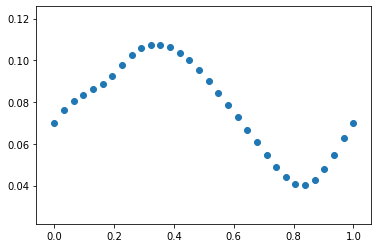

In [51]:
data = pd.read_csv('4x4y4z4i2B.csv')
plt.scatter(data['Phase'],data['diffMag'])

In [36]:
t0 = time.time()
stepTotal = 9
for i in range(1,10):
    time.sleep(1)
    timeLeft =str(int((((time.time() - t0)*(stepTotal)/i) - time.time() + t0)))
    print(timeLeft)

8
7
6
5
4
3
2
1
0
